# BEE 4750 Homework 2: Dissolved Oxygen

**Name**: Christine Swanson

**ID**: cms549

> **Due Date**
>
> Wednesday, 09/27/23, 9:00pm

## Overview

### Instructions

This assignment asks you to use a simulation model for dissolved oxygen
to assess the impacts of two wastewater streams, including minimum
treatment levels and the impact of uncertain environmental conditions.
You will also be asked to identify a minimum distance for the addition
of a third discharge stream.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [492]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

In [493]:
using Plots
using LaTeXStrings
using Distributions
using Statistics

## Problems (Total: 40 Points)

A river which flows at 6 km/d is receiving waste discharges from two
sources which are 15 km apart, as shown in
<a href="#fig-river" class="quarto-xref">Figure 1</a>. The oxygen
reaeration rate is 0.55 day<sup>-1</sup>, and the decay rates of CBOD
and NBOD are are 0.35 and 0.25 day<sup>-1</sup>, respectively. The
river’s saturated dissolved oxygen concentration is 10m g/L.

![Figure 1: Schematic of the
system](attachment:figures/river_diagram.png)

### Problem 1 (8 points)

If the characteristics of the river inflow and waste discharges are
given in <a href="#tbl-river" class="quarto-xref">Table 1</a>, write a
Julia model to compute the dissolved oxygen concentration from the first
wastewater discharge to an arbitrary distance `d` km downstream. Use
your model to compute the maximum dissolved oxygen concentration up to
50km downstream and how far downriver this maximum occurs.

|    Parameter     |            River Inflow |         Waste Stream 1 |         Waste Stream 2 |
|:----------------:|------------------------:|-----------------------:|-----------------------:|
|      Inflow      | 100,000 m<sup>3</sup>/d | 10,000 m<sup>3</sup>/d | 15,000 m<sup>3</sup>/d |
| DO Concentration |                7.5 mg/L |                 5 mg/L |                 5 mg/L |
|       CBOD       |                  5 mg/L |                50 mg/L |                45 mg/L |
|       NBOD       |                  5 mg/L |                35 mg/L |                35 mg/L |

Table 1: River inflow and waste stream characteristics for Problem 1.

In [494]:
# define variables before running function 

river_inflow = 100000
waste1_inflow = 10000

waste2_Ci = 5
waste2_inflow = 15000

B0 = 9.09 # calculated by hand
N0 = 7.73 # calculated by hand
C0 = 7.27 # calculated by hand

waste2_Bi = 45
waste2_Ni = 35

35

In [495]:
# revised DO model
function diss_oxygen(x, Cs, ka, kc, kn, U)
    if (x >= 0) && (x <= 15) # check if the distance is within the first section (0 to 15 km)

        # calculate decay factors
        a1 = exp(-ka * x / U)
        a2 = (kc / (ka - kc)) * (exp(-kc * x / U) - a1)
        a3 = (kn / (ka - kn)) * (exp(-kn * x / U) - a1)

        C = (Cs * (1 - a1)) + (C0 * a1) - (B0 * a2) - (N0 * a3) # calculate DO concentration 
        return C

    else # calculate distance in the second section (beyond 15 km)
        x2 = x - 15 # reset the distance at the second box

        # calculate decay factors for the second section
        a1 = exp(-ka * x2 / U)
        a2 = (kc / (ka - kc)) * (exp(-kc * x2 / U) - a1)
        a3 = (kn / (ka - kn)) * (exp(-kn * x2 / U) - a1)

        C_at_15 = 4.88 # initial DO concentration at 15 km, computed by hand

        # calculate mixed concentrations for the second section
        C_at_15_mixed = (((C_at_15 * (river_inflow + waste1_inflow)) + (waste2_Ci * waste2_inflow)) / (river_inflow + waste1_inflow + waste2_inflow))
        B_at_15_mixed = (((B0 * exp(-kc * 15 / U)) * (river_inflow + waste1_inflow)) + (waste2_Bi * waste2_inflow)) / (river_inflow + waste1_inflow + waste2_inflow)
        N_at_15_mixed = (((N0 * exp(-kn * 15 / U)) * (river_inflow + waste1_inflow)) + (waste2_Ni * waste2_inflow)) / (river_inflow + waste1_inflow + waste2_inflow)
        C = (Cs * (1 - a1)) + (C_at_15_mixed * a1) - (B_at_15_mixed * a2) - (N_at_15_mixed * a3)
        return C
    end
end

diss_oxygen (generic function with 1 method)

In [496]:
x = 0:0.1:50 

C = [] # create empty vector to store DO concentrations

for distance in x
    # calculate the [DO] at the current distance
    concentration = diss_oxygen(distance, 10, 0.55, 0.35, 0.25, 6)
    
    # append the concentration to initial vector
    push!(C, concentration)
end

In [497]:
# find minimum DO and where this occurs
x_axis = collect(0:0.1:50)
min_val = findmin(C) # find minimum value in the array and the associated index position
#x_axis[min_val[2]] # extract the distance

(3.754475723767745, 224)

In [498]:
# find maximum DO and where this occurs
x_axis = collect(0:0.1:50)
max_val = findmax(C) # find maximum value in the array and the associated index position
#x_axis[max_val[2]] # extract the distance

(7.27, 1)

Response: So, the minimum DO value is 3.75 mg/L, and this occurs approximately 22.4 km downstream. The maximum DO value occurs right at 0 km, with an associated value of 7.27 mg/L. 

### Problem 2 (4 points)

Use your model to plot the dissolved oxygen concentration in the river
from the first waste stream to 50km downstream. What do you notice?

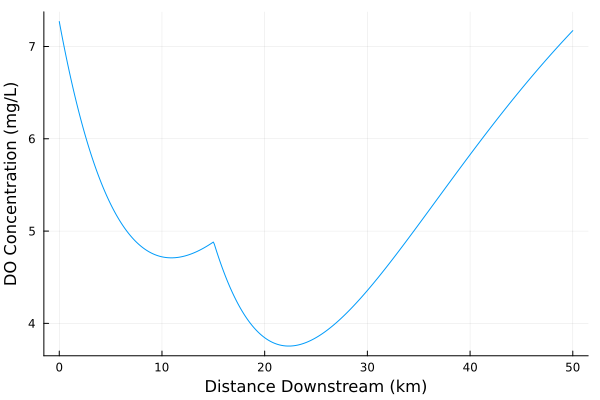

In [499]:
x_axis = collect(0:0.1:50) # create the x-axis for the plot
plot(x_axis, C, xlabel = "Distance Downstream (km)", ylabel = "DO Concentration (mg/L)", legend = false)

Response: From my plot, I notice that there are two "sag curves" smushed together, which is what I would expect. The DO concentration starts at 7.27 mg/L, and gradually drops down to slightly less than 5 mg/L at 15 km downstream. I also notice that the DO concentration dips below 4 mg/L after waste point 2. Then, the DO concentration recovers to a value greater than 7 mg/L near the 50 km mark.  

### Problem 3 (3 points)

Under the assumptions of Problem 1, determine the distance from waste
stream 2 it will take for the dissolved oxygen concentration of the
river to recover to 6 mg/L.

In [500]:
x = 15:0.1:50 # waste 2 distance

C2 = [] # create empty vector to store DO concentrations for waste stream 2

for distance in x
    # calculate the [DO] at the current distance
    concentration = diss_oxygen(distance, 10, 0.55, 0.35, 0.25, 6)
    
    # append the concentration to the C2 vector
    push!(C2, concentration)
end

In [501]:
# append values only greater than 6 from waste stream 2, then find index of the first occurance to get distance
C2_first = []

for i_val in C2
    if i_val >= 6
        push!(C2_first, i_val)
    end
end

In [502]:
# look through C2 to find first occurance of 6
# the value obtained divided by 100 gives you the distance
findall(item -> item == 6.0051169847438715, C2) 

1-element Vector{Int64}:
 263

Response: So, the distance from waste stream 2 for the DO concentration to recover to 6 mg/L is approximately 26.3 km downstream. 

### Problem 4 (5 points)

What is the minimum level of treatment (% removal of organic waste) for
waste stream 2 that will ensure that the dissolved oxygen concentration
never drops below 4 mg/L, assuming that waste stream 1 remains
untreated?

Response/Approach: For this problem, we want to reduce the CBOD and NBOD by a certain amount to get the treatment percentage. The code to do that is implemented below. I got a minimum level of treatment of around 7% for my final answer. 

In [503]:
# updated DO model for problem 4
function diss_oxygen2(x, Cs, ka, kc, kn, U, treatment_percentage) # add treatment percentage as an argument
    if (x >= 0) && (x <= 15)

        a1 = exp(-ka * x / U)
        a2 = (kc / (ka - kc)) * (exp(-kc * x / U) - a1)
        a3 = (kn / (ka - kn)) * (exp(-kn * x / U) - a1)

        C = (Cs * (1 - a1)) + (C0 * a1) - (B0 * a2) - (N0 * a3)
        return C

    else
        x2 = x - 15 # reset the distance at the second box

        a1 = exp(-ka * x2 / U)
        a2 = (kc / (ka - kc)) * (exp(-kc * x2 / U) - a1)
        a3 = (kn / (ka - kn)) * (exp(-kn * x2 / U) - a1)

        C_at_15 = 4.88 # computed by hand

        C_at_15_mixed = (((C_at_15 * (river_inflow + waste1_inflow)) + (waste2_Ci * waste2_inflow)) / (river_inflow + waste1_inflow + waste2_inflow))
        B_at_15_mixed = (((B0 * exp(-kc * 15 / U)) * (river_inflow + waste1_inflow)) + (waste2_Bi * waste2_inflow)) / (river_inflow + waste1_inflow + waste2_inflow)
        N_at_15_mixed = (((N0 * exp(-kn * 15 / U)) * (river_inflow + waste1_inflow)) + (waste2_Ni * waste2_inflow)) / (river_inflow + waste1_inflow + waste2_inflow)

        # apply treatment to waste stream 2 by updating the CBOD and NBOD mixed values at 15 km
        CBOD_treated = B_at_15_mixed * (1 - treatment_percentage / 100) # this approach is slightly off (see comment below)
        NBOD_treated = N_at_15_mixed * (1 - treatment_percentage / 100)

        C = (Cs * (1 - a1)) + (C_at_15_mixed * a1) - (CBOD_treated * a2) - (NBOD_treated * a3)
        return C
    end
end

diss_oxygen2 (generic function with 2 methods)

In [504]:
# range of treatment percentages to loop through
treatment_percentages = 0:1:100

threshold_results = []

for treatment_percentage in treatment_percentages
    DO_threshold = 4.0 # define [DO] threshold (4 mg/L)

    # set variables for the loop
    x = 0 
    C = diss_oxygen2(x, 10, 0.55, 0.35, 0.25, 6, treatment_percentage) # this will return C

    # increase x until DO gets to threshold
    while C >= DO_threshold && x <= 35.0 
        x += 0.1
        C = diss_oxygen2(x, 10, 0.55, 0.35, 0.25, 6, treatment_percentage)
    end

    # if DO is above the threshold, append to vector
    if C > DO_threshold
        push!(threshold_results, treatment_percentage)
    end
end

In [505]:
minimum(threshold_results) # minimum value from the threshold results vector

7

Clarification of my approach: For question 4, I originally tried to change the CBOD and NBOD treated by multiplying waste2_Bi and waste2_Ni by (1 - the treatment percentage). But, unfortunately this (correct) approach did not work as I got a minimum value of 1 for the treatment percentage through this approach. Becuase a value of 7% is closer to what I would expect (even though the code conceptually is slightly off), I left the code as it is shown currently for problem #4.  

### Problem 5 (5 points)

If both waste streams are treated equally, what is the minimum level of
treatment (% removal of organic waste) for the two sources required to
ensure that the dissolved oxygen concentration never drops below 4 mg/L?

In [506]:
# define variables

waste1_Bi = 50
waste1_Ni = 35

do_river = 7.5
waste1_do = 5

cbod_river = 5
waste1_cbod = 50

nbod_river = 5
waste1_nbod = 35

35

In [507]:
# updated DO model for problem 5
function diss_oxygen3(x, Cs, ka, kc, kn, U, treatment_percentage)
    if (x >= 0) && (x <= 15)
        
        a1 = exp(-ka * x / U)
        a2 = (kc / (ka - kc)) * (exp(-kc * x / U) - a1)
        a3 = (kn / (ka - kn)) * (exp(-kn * x / U) - a1)
        # update C
        C = (Cs * (1 - a1)) + (C0 * a1) - (waste1_Bi * (1 - treatment_percentage / 100) * a2) - (waste1_Ni * (1 - treatment_percentage / 100)* a3)
        return C

    else
        x2 = x - 15 # reset the distance at the second box

        a1 = exp(-ka * x2 / U)
        a2 = (kc / (ka - kc)) * (exp(-kc * x2 / U) - a1)
        a3 = (kn / (ka - kn)) * (exp(-kn * x2 / U) - a1)

        C_at_15 = 4.88 # computed by hand

        C_at_15_mixed = (((C_at_15 * (river_inflow + waste1_inflow)) + (waste2_Ci * waste2_inflow)) / (river_inflow + waste1_inflow + waste2_inflow))
        B_at_15_mixed = (((B0 * exp(-kc * 15 / U)) * (river_inflow + waste1_inflow)) + (waste2_Bi * waste2_inflow)) / (river_inflow + waste1_inflow + waste2_inflow)
        N_at_15_mixed = (((N0 * exp(-kn * 15 / U)) * (river_inflow + waste1_inflow)) + (waste2_Ni * waste2_inflow)) / (river_inflow + waste1_inflow + waste2_inflow)

        # apply treatment to waste stream 2 by updating the CBOD and NBOD mixed values at 15 km
        CBOD_treated = B_at_15_mixed * (1 - treatment_percentage / 100) # this approach is slightly off (see comment below)
        NBOD_treated = N_at_15_mixed * (1 - treatment_percentage / 100)

        C = (Cs * (1 - a1)) + (C_at_15_mixed * a1) - (CBOD_treated * a2) - (NBOD_treated * a3)
        return C
    end
end

diss_oxygen3 (generic function with 2 methods)

In [508]:
# range of treatment percentages to loop through
treatment_percentages = 0:1:100

threshold_results2 = []

for treatment_percentage in treatment_percentages
    DO_threshold = 4.0 # define [DO] threshold (4 mg/L)

    # set variables for the loop
    x = 0 
    C = diss_oxygen3(x, 10, 0.55, 0.35, 0.25, 6, treatment_percentage) # this will return C

    # increase x until DO gets to threshold
    while C >= DO_threshold && x <= 50.0 
        x += 0.1
        C = diss_oxygen3(x, 10, 0.55, 0.35, 0.25, 6, treatment_percentage)
    end

    # if DO is above the threshold, append to vector
    if C > DO_threshold
        push!(threshold_results2, treatment_percentage)
    end
end

In [509]:
minimum(threshold_results2/10) # minimum value from vector

7.8

Response: I attempted to implement the approach where you multiply (1 - treatment_percentage) by the waste1_Bi and waste1_Ni variables, respectively. I think there is still something slightly off with the code, but nonetheless I got a value of approximately 7.8% for question #5.

### Problem 6 (5 points)

Suppose you are responsible for designing a waste treatment plan for
discharges into the river, with a regulatory mandate to keep the
dissolved oxygen concentration above 4 mg/L. Discuss whether you’d opt
to treat waste stream 2 alone or both waste streams equally. What other
information might you need to make a conclusion, if any?

Response: With an unlimited amount of money, I would treat both streams equally in order to ensure we are complying with the regulatory mandate and doing the most we can to protect the environment, particularly with respect to aquatic ecosystems. But, we often do not deal with unlimited money in the real world, so it might make sense to just treat waste stream 2 because that would satisfy meeting the regulatory mandate. Other information we might need to consider include data on costs acceptable for treatment, whether we have the infrastructure/facilities available to treat both waste streams, and also perhaps what the public or stakeholders think about the problem regarding treating both waste streams or not. 

### Problem 7 (5 points)

Suppose that it is known that the DO concentrations at the river inflow
can vary uniformly between 6 mg/L and 8 mg/L. How often will the
treatment plan identified in Problem 5 (both waste streams treated
equally) fail to comply with the regulatory standard?

In [510]:
do_inflow_range = 6:0.1:8 # how DO inflow can vary according to problem 

treatment_percentages = 0:1:100 # treatments to loop through

failure_count = 0 # counter for failures

dist = collect(0:0.1:50) # examining entire length of river

for do_inflow in do_inflow_range
    for treatment_percentage in treatment_percentages
        for di in dist # need to loop through the distances along the entire river
            final_DO = diss_oxygen3(di, 10, 0.55, 0.35, 0.25, do_inflow, treatment_percentage) # call the function from question 5
            # check if the treatment plan fails to comply with regulatory standard
            if final_DO < 4
                failure_count += 1
                break  # need to exit loop once DO gets below 4 mg/L
            end
        end
    end
end

# calculate failure rate
# because we have a range of DO inflows and a range of treatments, we need to multiply these results together
all_options = length(do_inflow_range) * length(treatment_percentages) 
failure_frac = failure_count / all_options

0.7722772277227723

In [511]:
round(failure_frac*100)

77.0

Response: I recognize that there are still some carry-over issues from problem 5. Nonetheless, I believe my approach for this problem is generally correct, leading me to get a failure percentage of approximately 77% for the treatment plan from problem 5. 

So, my overall approach is to loop through various DO inflow values (ranging from 6 to 8), treatment percentages, and distances along the river to get an understanding of the success of the treatment plan under different conditions. So, ultimately the `failure_frac` variable provides me with an estimate of how often the plan fails to comply with the regulatory standard of 4 mg/L.

### Problem 8 (5 points)

A factory is planning a third wastewater discharge into the river
downstream of the second plant. This discharge would consist of 5
m<sup>3</sup>/day of wastewater with a dissolved oxygen content of 4.5
mg/L and CBOD and NBOD levels of 50 and 45 mg/L, respectively.

Assume that the treatment plan you identified in Problem 5 is still in
place for the existing discharges. If the third discharge will not be
treated, under the original inflow conditions (7.5 mg/L DO), how far
downstream from the second discharge does this third discharge need to
be placed to keep the river concentration from dropping below 4 mg/L?

In [512]:
# define variables
do_inflow = 7.5 
waste3_inflow = 5000 # waste stream 3
waste3_DO = 4.5 # waste stream 3
waste3_CBOD = 50.0 # waste stream 3
waste3_NBOD = 45.0 # waste stream 3
ka = 0.55
kc = 0.35
kn = 0.25
U = 6
Cs = 10

# set initial conditions of river
C0 = 7.27
B0 = (((cbod_river * river_inflow) + (waste1_cbod * waste1_inflow)) / (river_inflow + waste1_inflow))
N0 = (((nbod_river * river_inflow ) + (waste1_nbod * waste1_inflow)) / (river_inflow + waste1_inflow))

7.7272727272727275

In [513]:
# function to calculate mixed [DO] 
# here, update the code from problem 5
function calculate_mixed_DO(x, treatment_percentage)
    if (x >= 0) && (x <= 15)
        a1 = exp(-ka * x / U)
        a2 = (kc / (ka - kc)) * (exp(-kc * x / U) - a1)
        a3 = (kn / (ka - kn)) * (exp(-kn * x / U) - a1)

        # update C using the treatment for waste stream 1
        C = (Cs * (1 - a1)) + (C0 * a1) - (waste1_Bi * (1 - treatment_percentage / 100) * a2) - (waste1_Ni * (1 - treatment_percentage / 100) * a3)
        return C
    else
        x2 = x - 15 # reset the distance at the second box

        a1 = exp(-ka * x2 / U)
        a2 = (kc / (ka - kc)) * (exp(-kc * x2 / U) - a1)
        a3 = (kn / (ka - kn)) * (exp(-kn * x2 / U) - a1)

        # calculate mixed values at 15 km
        C_at_15 = 4.88 # Computed by hand
        B_at_15_mixed = (((B0 * exp(-kc * 15 / U)) * (river_inflow + waste1_inflow)) + (waste2_Bi * waste2_inflow)) / (river_inflow + waste1_inflow + waste2_inflow)
        N_at_15_mixed = (((N0 * exp(-kn * 15 / U)) * (river_inflow + waste1_inflow)) + (waste2_Ni * waste2_inflow)) / (river_inflow + waste1_inflow + waste2_inflow)

        # apply treatment to waste stream 2 by updating the CBOD and NBOD mixed values at 15 km
        CBOD_treated = B_at_15_mixed * (1 - treatment_percentage / 100)
        NBOD_treated = N_at_15_mixed * (1 - treatment_percentage / 100)

        # calculate mixed DO concentration beyond the first box
        C_mixed = (C_at_15 * (1 - a1)) + (C0 * a1) - (CBOD_treated * a2) - (NBOD_treated * a3)

        return C_mixed
    end
end

calculate_mixed_DO (generic function with 1 method)

Note: I think I need to implement a loop after this to find the minimum distance from waste stream 2 to put the third discharge (i.e., loop over a vector of distances). But I'm not sure how to implement. I am trying to modify the code from problem 5 to tackle this problem, but am having some difficulties.  

## References

List any external references consulted, including classmates.

I consulted with Akshara during parts of this assignment. 

This link showed me how to use the `findall` function: https://docs.julialang.org/en/v1/base/arrays/#Base.findall-Tuple{Any}

This link showed me how to use the `collect` function: https://docs.julialang.org/en/v1/manual/arrays/#man-array-concatenation